In [372]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import cartopy.feature as cfeature
import os
from sklearn.linear_model import LinearRegression
from scipy.stats import gaussian_kde

In [34]:
import xesmf as xe

In [35]:
home_path = os.path.expanduser("~")

path = '/DataFiles'
path2 = '/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - MacBook Air/Python/Ice Cores/data/model/ccsm4_last_millenium'

racmo = xr.open_dataset(home_path + path + "/smb_monthlyS_ANT27_ERA5-3H_RACMO2.3p2_197901_202212.nc")
mask = xr.open_dataset(home_path + path + "/TotIS_RACMO_ANT27_IMBIE2.nc")

In [36]:
def compute_2d_bounds(arr):
    """
    Compute approximate 2D cell corner bounds for a 2D array.
    arr: 2D array of lat or lon with shape (ny, nx)
    Returns: 2D array of bounds with shape (ny+1, nx+1)
    """
    ny, nx = arr.shape

    # Compute interior points
    b = 0.5 * (arr[:-1, :-1] + arr[1:, 1:])

    # For edges, extend by copying first/last rows and columns
    b_full = np.zeros((ny+1, nx+1))
    # Fill interior
    b_full[1:-1, 1:-1] = 0.25*(arr[:-1, :-1] + arr[1:, :-1] + arr[:-1, 1:] + arr[1:, 1:])
    # Top/bottom edges
    b_full[0,1:-1] = arr[0,:-1] - 0.5*(arr[1,:-1]-arr[0,:-1])
    b_full[-1,1:-1] = arr[-1,:-1] + 0.5*(arr[-1,:-1]-arr[-2,:-1])
    # Left/right edges
    b_full[1:-1,0] = arr[:-1,0] - 0.5*(arr[:-1,1]-arr[:-1,0])
    b_full[1:-1,-1] = arr[:-1,-1] + 0.5*(arr[:-1,-1]-arr[:-1,-2])
    # Corners (copy nearest interior)
    b_full[0,0] = b_full[1,1]
    b_full[0,-1] = b_full[1,-2]
    b_full[-1,0] = b_full[-2,1]
    b_full[-1,-1] = b_full[-2,-2]

    return b_full

# Extract lat/lon from RACMO (2D DataArrays)
lat = racmo["lat"].values
lon = racmo["lon"].values

# Compute approximate 2D bounds
lat_b = compute_2d_bounds(lat)
lon_b = compute_2d_bounds(lon)

# Create new xarray Dataset for xESMF
grid_ds = xr.Dataset(
    {
        "lat": (["y", "x"], lat),
        "lon": (["y", "x"], lon),
        "lat_b": (["y_b", "x_b"], lat_b),
        "lon_b": (["y_b", "x_b"], lon_b),
    }
)

print(grid_ds)

cellArea = xe.util.cell_area(grid_ds, earth_radius=6371.0)  # km²
threshold = 800  # km²

cellArea_fixed = cellArea.copy()

# Loop over each latitude row
for i in range(cellArea_fixed.shape[0]):
    # Compute mean of cells below threshold for this row
    row_mean = cellArea_fixed[i, :].where(cellArea_fixed[i, :] <= threshold).mean()
    # Replace cells above threshold with row mean
    cellArea_fixed[i, :] = xr.where(cellArea_fixed[i, :] > threshold, row_mean, cellArea_fixed[i, :])

smb = racmo["smb"].squeeze("height")
smb_ann = smb.groupby("time.year").sum(dim="time").sel(year=slice(1979, 2000))


lat = racmo["lat"].values  # shape (rlat, rlon)
lon = racmo["lon"].values

cell_area_da = xr.DataArray(cellArea_fixed, dims=("rlat","rlon"))

smb_mass_ann = smb_ann * cell_area_da * 1000000

antarctic_smb_Gt_ann = smb_mass_ann.sum(dim=("rlat","rlon")) / 1e12




<xarray.Dataset> Size: 2MB
Dimensions:  (y: 240, x: 262, y_b: 241, x_b: 263)
Dimensions without coordinates: y, x, y_b, x_b
Data variables:
    lat      (y, x) float64 503kB -46.75 -46.92 -47.09 ... -47.42 -47.24 -47.07
    lon      (y, x) float64 503kB -126.9 -127.1 -127.3 ... 52.84 53.03 53.23
    lat_b    (y_b, x_b) float64 507kB -46.91 -46.67 -46.84 ... -47.17 -47.24
    lon_b    (y_b, x_b) float64 507kB -126.8 -127.0 -127.2 ... 52.69 52.89 53.28


In [ ]:
# --- 1️⃣  Prepare core inputs ---

# Annual SMB (kg m⁻² per year)
smb = racmo["smb"].squeeze("height")
smb_ann = smb.groupby("time.year").sum(dim="time").sel(year=slice(1979, 2000))

# Cell area in km² → convert to m²
cell_area_m2 = cellArea_fixed * 1e6  # from km² to m²
cell_area_da = xr.DataArray(cell_area_m2, dims=("rlat","rlon"))

# Drainage basin mask (values 1–18 or similar)
basin_mask = mask["GroundedIce"]

# Apply same grid dimensions
basin_mask = basin_mask.where(~np.isnan(basin_mask), 0)

# --- 2️⃣  Compute SMB mass for each grid cell (kg) ---

smb_mass_ann = smb_ann * cell_area_da  # kg per grid cell

# --- 3️⃣  Flatten arrays for vectorized basin summation ---

nlat, nlon = basin_mask.shape
basin_flat = basin_mask.values.reshape(nlat * nlon)
valid_mask = (basin_flat > 0) & np.isfinite(basin_flat)
basin_ids = basin_flat[valid_mask].astype(int)

# Prepare an output DataFrame (years × basins)
years = smb_ann["year"].values
basin_ids_unique = np.unique(basin_ids)
smb_per_basin_Gt = pd.DataFrame(index=years, columns=basin_ids_unique)

# --- 4️⃣  Loop over years efficiently ---
for i, yr in enumerate(years):
    smb_yr = smb_mass_ann.sel(year=yr).values.reshape(nlat * nlon)
    smb_valid = smb_yr[valid_mask]  # only grounded cells
    df = pd.DataFrame({"basin": basin_ids, "mass_kg": smb_valid})
    smb_sum = df.groupby("basin")["mass_kg"].sum() / 1e12  # kg → Gt
    smb_per_basin_Gt.loc[yr, smb_sum.index] = smb_sum.values

# --- 5️⃣  Done ---
#print(smb_per_basin_Gt)


In [47]:
ais_smb = smb_per_basin_Gt.sum(axis=1)
wais_smb = smb_per_basin_Gt[[3,7,8,9,10]].sum(axis=1)
eais_smb = smb_per_basin_Gt[[1,2,11,12,13,14,15,16,17,18]].sum(axis=1)
ap_smb = smb_per_basin_Gt[[4,5,6]].sum(axis=1)


In [ ]:
# --- 1️⃣ Annual SMB per grid cell ---
smb_ann = racmo["smb"].squeeze("height").groupby("time.year").sum(dim="time").sel(year=slice(1979, 2000))

# --- 2️⃣ Total Antarctic SMB (Gt/yr) ---
ais_smb = smb_per_basin_Gt.sum(axis=1).sort_index()
ais_smb_anom = (ais_smb - ais_smb.mean()) / ais_smb.std()

# --- 3️⃣ Convert ais_smb to xarray DataArray ---
ais_smb_da = xr.DataArray(
    ais_smb_anom.values.astype(float),
    dims=["year"],
    coords={"year": smb_ann["year"].values}
)

# --- 4️⃣ Define robust correlation function ---
def corr_func(smb_ts, ais_ts):
    smb_ts = np.asarray(smb_ts, dtype=float)
    ais_ts = np.asarray(ais_ts, dtype=float)
    mask = np.isfinite(smb_ts) & np.isfinite(ais_ts)
    if mask.sum() < 2:
        return np.nan
    return np.corrcoef(smb_ts[mask], ais_ts[mask])[0, 1]

# --- 5️⃣ Compute correlation map ---
ais_corr_map = xr.apply_ufunc(
    corr_func,
    smb_ann, ais_smb_da,
    input_core_dims=[["year"], ["year"]],
    output_core_dims=[[]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[float]
)



/opt/anaconda3/envs/xesmf-env/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


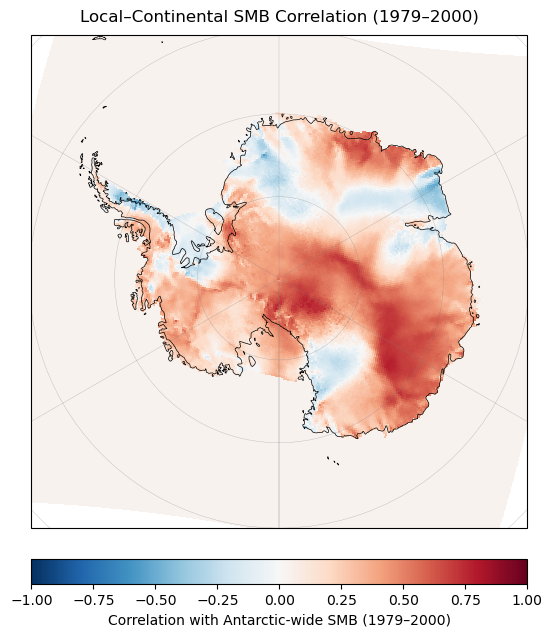

In [49]:
# Define projection
proj = ccrs.SouthPolarStereo()

# Create figure and axes
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=proj)

# Set extent to include all Antarctica (lon from -180 to 180)
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())

# Plot correlation map
im = ax.pcolormesh(
    racmo["lon"], racmo["lat"], ais_corr_map,
    transform=ccrs.PlateCarree(),
    cmap="RdBu_r", vmin=-1, vmax=1
)

# Add colorbar
cb = plt.colorbar(im, ax=ax, orientation="horizontal", pad=0.05, shrink=0.8)
cb.set_label("Correlation with Antarctic-wide SMB (1979–2000)")

# Add geographic features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, color="black")
ax.add_feature(cfeature.LAND, facecolor="lightgray", zorder=0)

# Add gridlines
gl = ax.gridlines(draw_labels=False, linewidth=0.3, color="gray", alpha=0.5)
gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 60))

# Add title
plt.title("Local–Continental SMB Correlation (1979–2000)", fontsize=12, pad=10)

plt.show()


In [51]:
# --- 1️⃣ Annual SMB per grid cell ---
smb_ann = (
    racmo["smb"]
    .squeeze("height")
    .groupby("time.year")
    .sum(dim="time")
    .sel(year=slice(1979, 2000))
)

# --- 2️⃣ Define basin-based SMB totals (Gt/yr) ---
ais_smb  = smb_per_basin_Gt.sum(axis=1)
wais_smb = smb_per_basin_Gt[[3,7,8,9,10]].sum(axis=1)
eais_smb = smb_per_basin_Gt[[1,2,11,12,13,14,15,16,17,18]].sum(axis=1)
ap_smb   = smb_per_basin_Gt[[4,5,6]].sum(axis=1)

# --- 3️⃣ Normalize each series (anomaly in std units) ---
def normalize(series):
    return (series - series.mean()) / series.std()

ais_smb_anom  = normalize(ais_smb)
wais_smb_anom = normalize(wais_smb)
eais_smb_anom = normalize(eais_smb)
ap_smb_anom   = normalize(ap_smb)

# --- 4️⃣ Convert each to xarray DataArray for xarray compatibility ---
def to_xr(series, smb_ann):
    return xr.DataArray(
        series.values.astype(float),
        dims=["year"],
        coords={"year": smb_ann["year"].values}
    )

ais_smb_da  = to_xr(ais_smb_anom, smb_ann)
wais_smb_da = to_xr(wais_smb_anom, smb_ann)
eais_smb_da = to_xr(eais_smb_anom, smb_ann)
ap_smb_da   = to_xr(ap_smb_anom, smb_ann)

# --- 5️⃣ Robust correlation function ---
def corr_func(smb_ts, region_ts):
    smb_ts = np.asarray(smb_ts, dtype=float)
    region_ts = np.asarray(region_ts, dtype=float)
    mask = np.isfinite(smb_ts) & np.isfinite(region_ts)
    if mask.sum() < 2:
        return np.nan
    return np.corrcoef(smb_ts[mask], region_ts[mask])[0, 1]

# --- 6️⃣ Compute correlation maps for each region ---
def compute_corr_map(region_da):
    return xr.apply_ufunc(
        corr_func,
        smb_ann, region_da,
        input_core_dims=[["year"], ["year"]],
        output_core_dims=[[]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float]
    )

ais_corr_map  = compute_corr_map(ais_smb_da)
wais_corr_map = compute_corr_map(wais_smb_da)
eais_corr_map = compute_corr_map(eais_smb_da)
ap_corr_map   = compute_corr_map(ap_smb_da)


In [246]:
ais_accum_racmo = np.asarray(pd.to_numeric(ais_smb, errors='coerce'), dtype=float)
wais_accum_racmo = np.asarray(pd.to_numeric(wais_smb, errors='coerce'), dtype=float)
eais_accum_racmo = np.asarray(pd.to_numeric(eais_smb, errors='coerce'), dtype=float)
ap_accum_racmo = np.asarray(pd.to_numeric(ap_smb, errors='coerce'), dtype=float)

years = np.arange(1979, 2001)

In [56]:
# --- 7️⃣ Correlation maps for each individual basin (1–18) ---

# Ensure basin numbering matches smb_per_basin_Gt columns
n_basins = smb_per_basin_Gt.shape[1]

basin_corr_maps = {}

for basin_id in range(1, n_basins + 1):
    # Select and normalize basin SMB time series
    basin_smb = smb_per_basin_Gt[basin_id]
    basin_smb_anom = normalize(basin_smb)
    
    # Convert to xarray DataArray
    basin_da = to_xr(basin_smb_anom, smb_ann)
    
    # Compute correlation map for this basin
    corr_map = compute_corr_map(basin_da)
    
    # Store in dictionary with a clear key
    basin_corr_maps[f"basin_{basin_id:02d}"] = corr_map

# Example access:
# basin_corr_maps["basin_03"].plot()


/var/folders/4d/5th1wr_s21g614c74mcbh9kc0000gn/T/ipykernel_56105/2968360124.py:6: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  nlat, nlon = mask.dims["lat"], mask.dims["lon"]


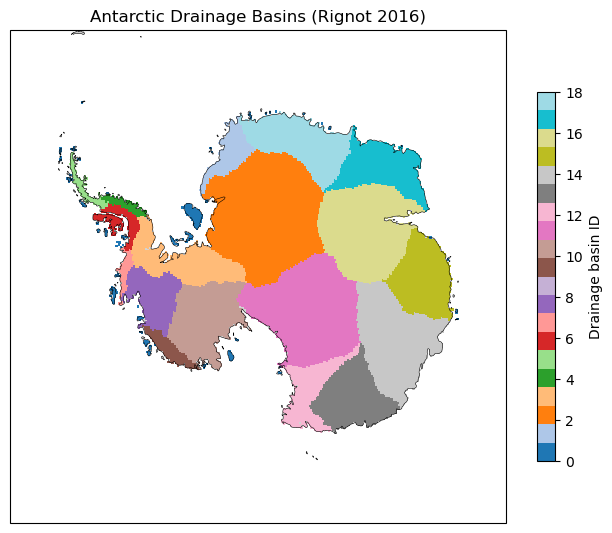

In [77]:
# Extract coordinate arrays
lat_attr = np.array(mask.GroundedIce.attrs["lat2d"])
lon_attr = np.array(mask.GroundedIce.attrs["lon2d"])

# Reshape to 2D
nlat, nlon = mask.dims["lat"], mask.dims["lon"]
lats2d = lat_attr.reshape(nlat, nlon)
lons2d = lon_attr.reshape(nlat, nlon)

# Attach as coordinates
basins = mask["GroundedIce"].copy()
basins = basins.assign_coords(lat=(("lat", "lon"), lats2d),
                              lon=(("lat", "lon"), lons2d))
                              
proj = ccrs.SouthPolarStereo()
data_crs = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': proj})
ax.set_extent([-180, 180, -90, -60], crs=data_crs)

ax.add_feature(cfeature.COASTLINE, linewidth=0.4)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Filled basins
im = ax.pcolormesh(
    basins.lon, basins.lat, basins,
    transform=data_crs,
    cmap='tab20'
)


plt.colorbar(im, ax=ax, shrink=0.6, label="Drainage basin ID")
ax.set_title("Antarctic Drainage Basins (Rignot 2016)", fontsize=12)
plt.show()

In [272]:
# Loading the ice core accumulation records
accumData = pd.read_csv(home_path + path + "/AccumCoresData.csv", header=None)
accumCores = accumData.iloc[2:, 1:][
    (accumData.iloc[2:, 0].astype(int) >= 1979) & (accumData.iloc[2:, 0].astype(int) <= 2000)
].to_numpy()[::-1]
accumCores = accumCores.astype(float)

# loading core metadata
prCoords = pd.read_csv(home_path + path + "/AccumCoresCoords.csv", header=None)
core_lats = prCoords.iloc[:, 2].values
coresLonFirst = prCoords.iloc[:, 3].values
core_lons = (coresLonFirst + 360) % 360
core_names = prCoords.iloc[:, 0].values

accumCoresFull = accumData.iloc[2:, 1:][
    (accumData.iloc[2:, 0].astype(int) >= 1801) & (accumData.iloc[2:, 0].astype(int) <= 2000)
].to_numpy()[::-1]
accumCoresFull = accumCoresFull.astype(float)


In [542]:
# computing core to grid cell RACMO correlations, linear regression
record_site_corr = np.zeros(len(core_lats))
record_site_slope = np.zeros(len(core_lats))
record_site_intercept = np.zeros(len(core_lats))
record_error_var = np.zeros(len(core_lats))

racmo_points = np.zeros((22, 84))

for i in range(len(core_lats)):
    target_lat = core_lats[i]
    target_lon = core_lons[i]

    target_lon = (target_lon + 360) % 360
    lon2d = (smb_ann['lon'].values + 360) % 360
    lat2d = smb_ann['lat'].values

    dist2 = (lat2d - target_lat)**2 + (lon2d - target_lon)**2
    j, k = np.unravel_index(np.argmin(dist2), dist2.shape)

    smb_point = smb_ann.isel(rlat=j, rlon=k)

    obs = accumCores[:, i]

    # Mask invalid values
    valid = np.isfinite(obs) & np.isfinite(smb_point)
    valid_idx = np.where(valid)[0]  # plain NumPy indices

    smb_valid = smb_point[valid_idx]
    obs_valid = obs[valid_idx]

    racmo_points[:, i] = smb_point

    y = np.array(smb_point[valid]).reshape(-1, 1)
    x = np.array(obs[valid]).reshape(-1, 1)
    

    record_site_corr[i] = np.corrcoef(smb_point[valid], obs[valid])[0, 1]

    # Linear regression (least squares)
    reg = LinearRegression().fit(x, y)
    slope = reg.coef_[0][0]
    intercept = reg.intercept_[0]

    record_site_slope[i] = slope
    record_site_intercept[i] = intercept

    y_pred = lm.predict(x)

    error_var = np.var(y - y_pred, ddof=1)
    total_var = np.var(y, ddof=1)
    #record_error_var[i] = error_var / total_var
    record_error_var[i] = error_var


In [439]:
site_PSM = np.zeros((200, len(core_lats)))

for i in range(len(core_lats)):
    slope = record_site_slope[i]
    intercept = record_site_intercept[i]
    for j in range(200):
        site_PSM[j, i] = slope * accumCoresFull[j, i] + intercept

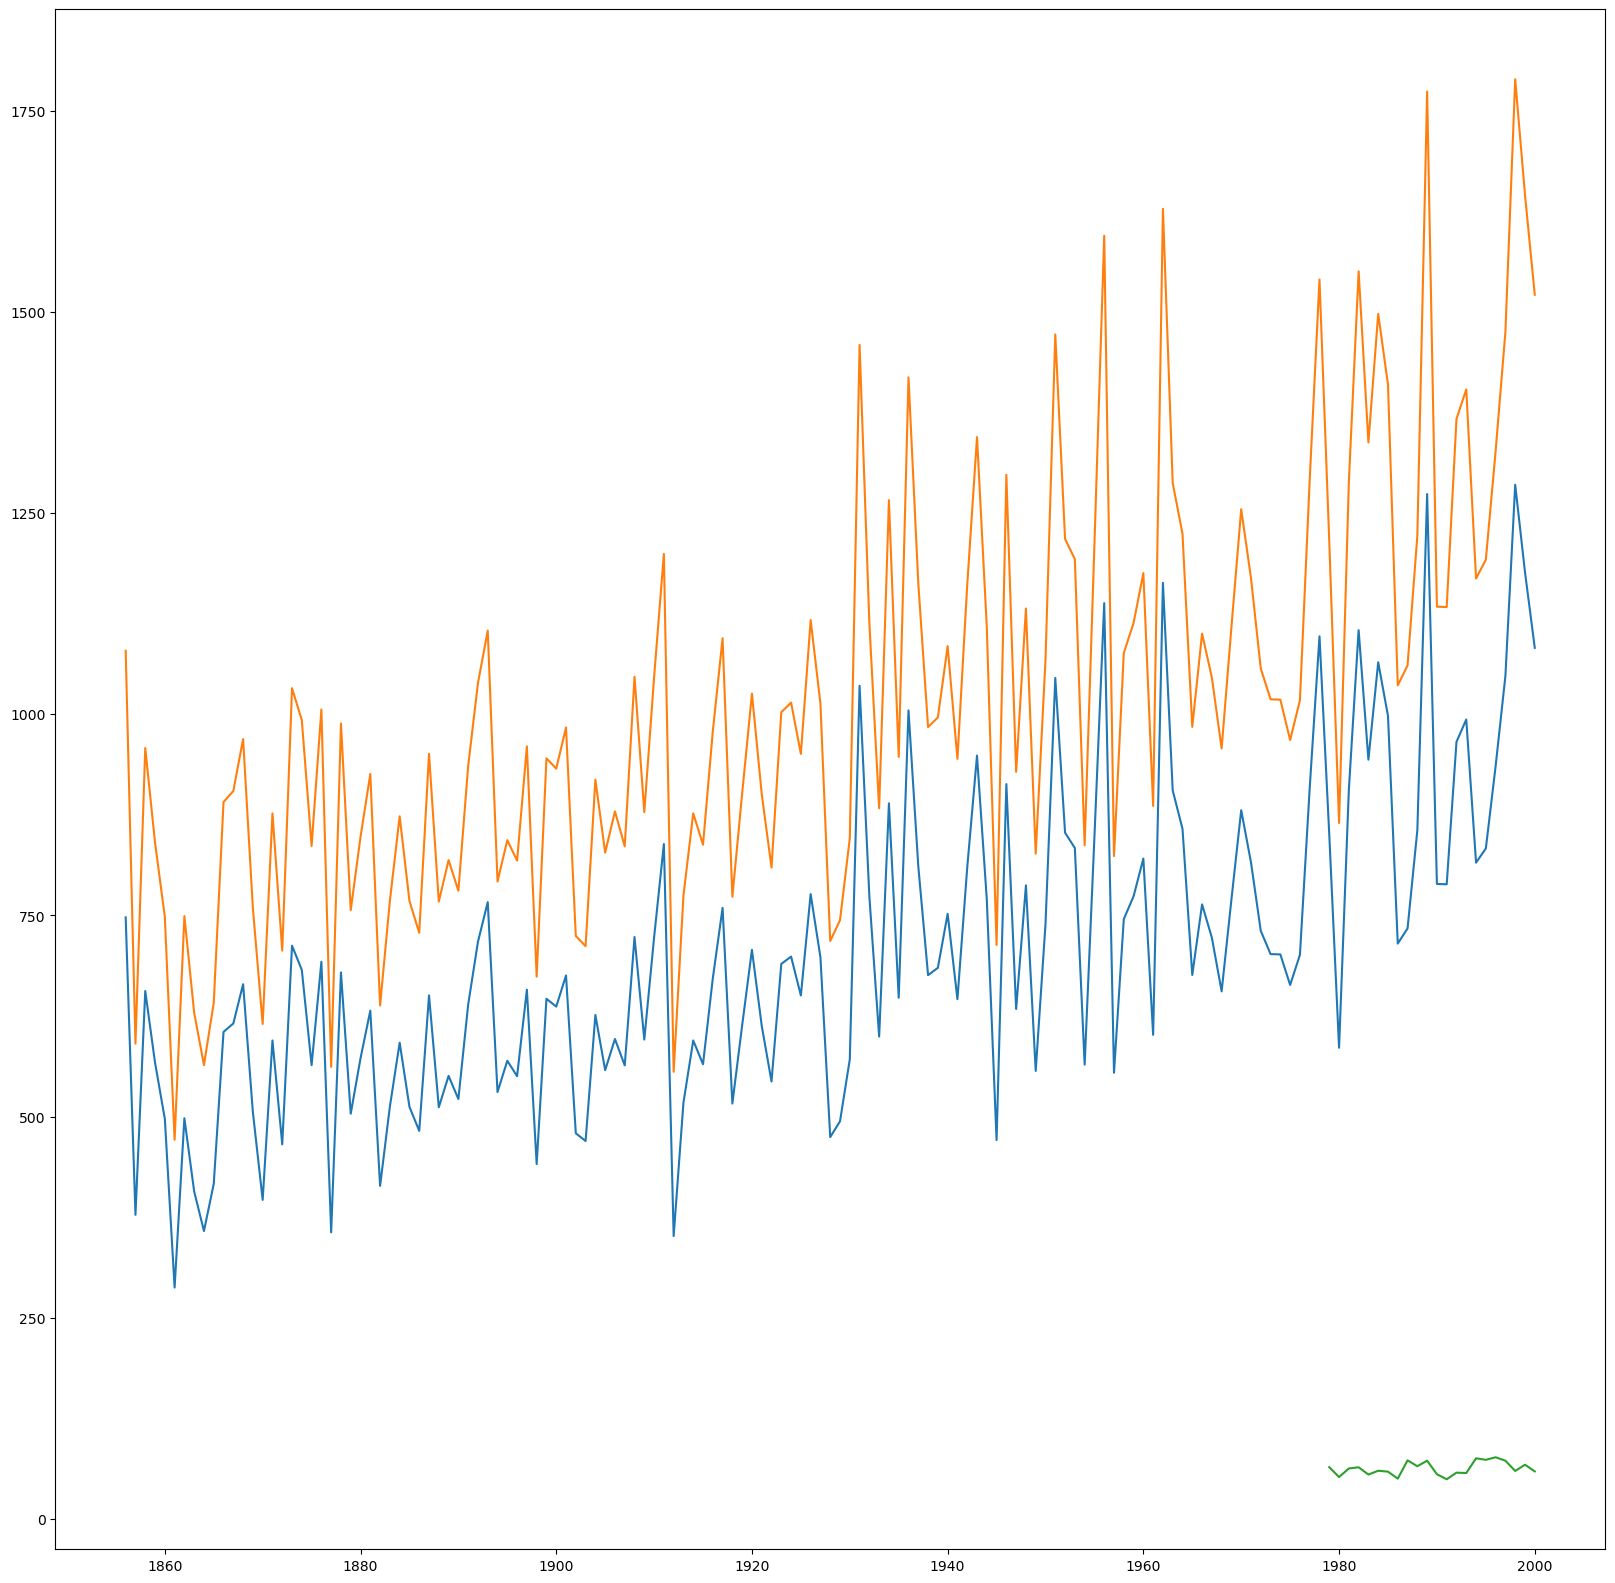

In [538]:
fullYears = np.arange(1801, 2001, 1)
plt.plot(fullYears, accumCoresFull[:, 37], label='Ice Core')
plt.plot(fullYears, site_PSM[:, 37], label='PSM')
plt.plot(satYears, racmo_points[:, 15], label='RACMO')

In [408]:
print(racmo_points[:, 0])

[15.9315815  21.04797363 27.93905067 25.77487373 19.33104324 26.64474869
 22.20810509 25.09510422 23.94470596 19.76788902 24.2537384  21.42741013
 19.55421257 22.99942207 30.50405121 17.60622787 20.48260307 20.99212265
 18.0358963  20.95492935 27.31639481 20.31937599]


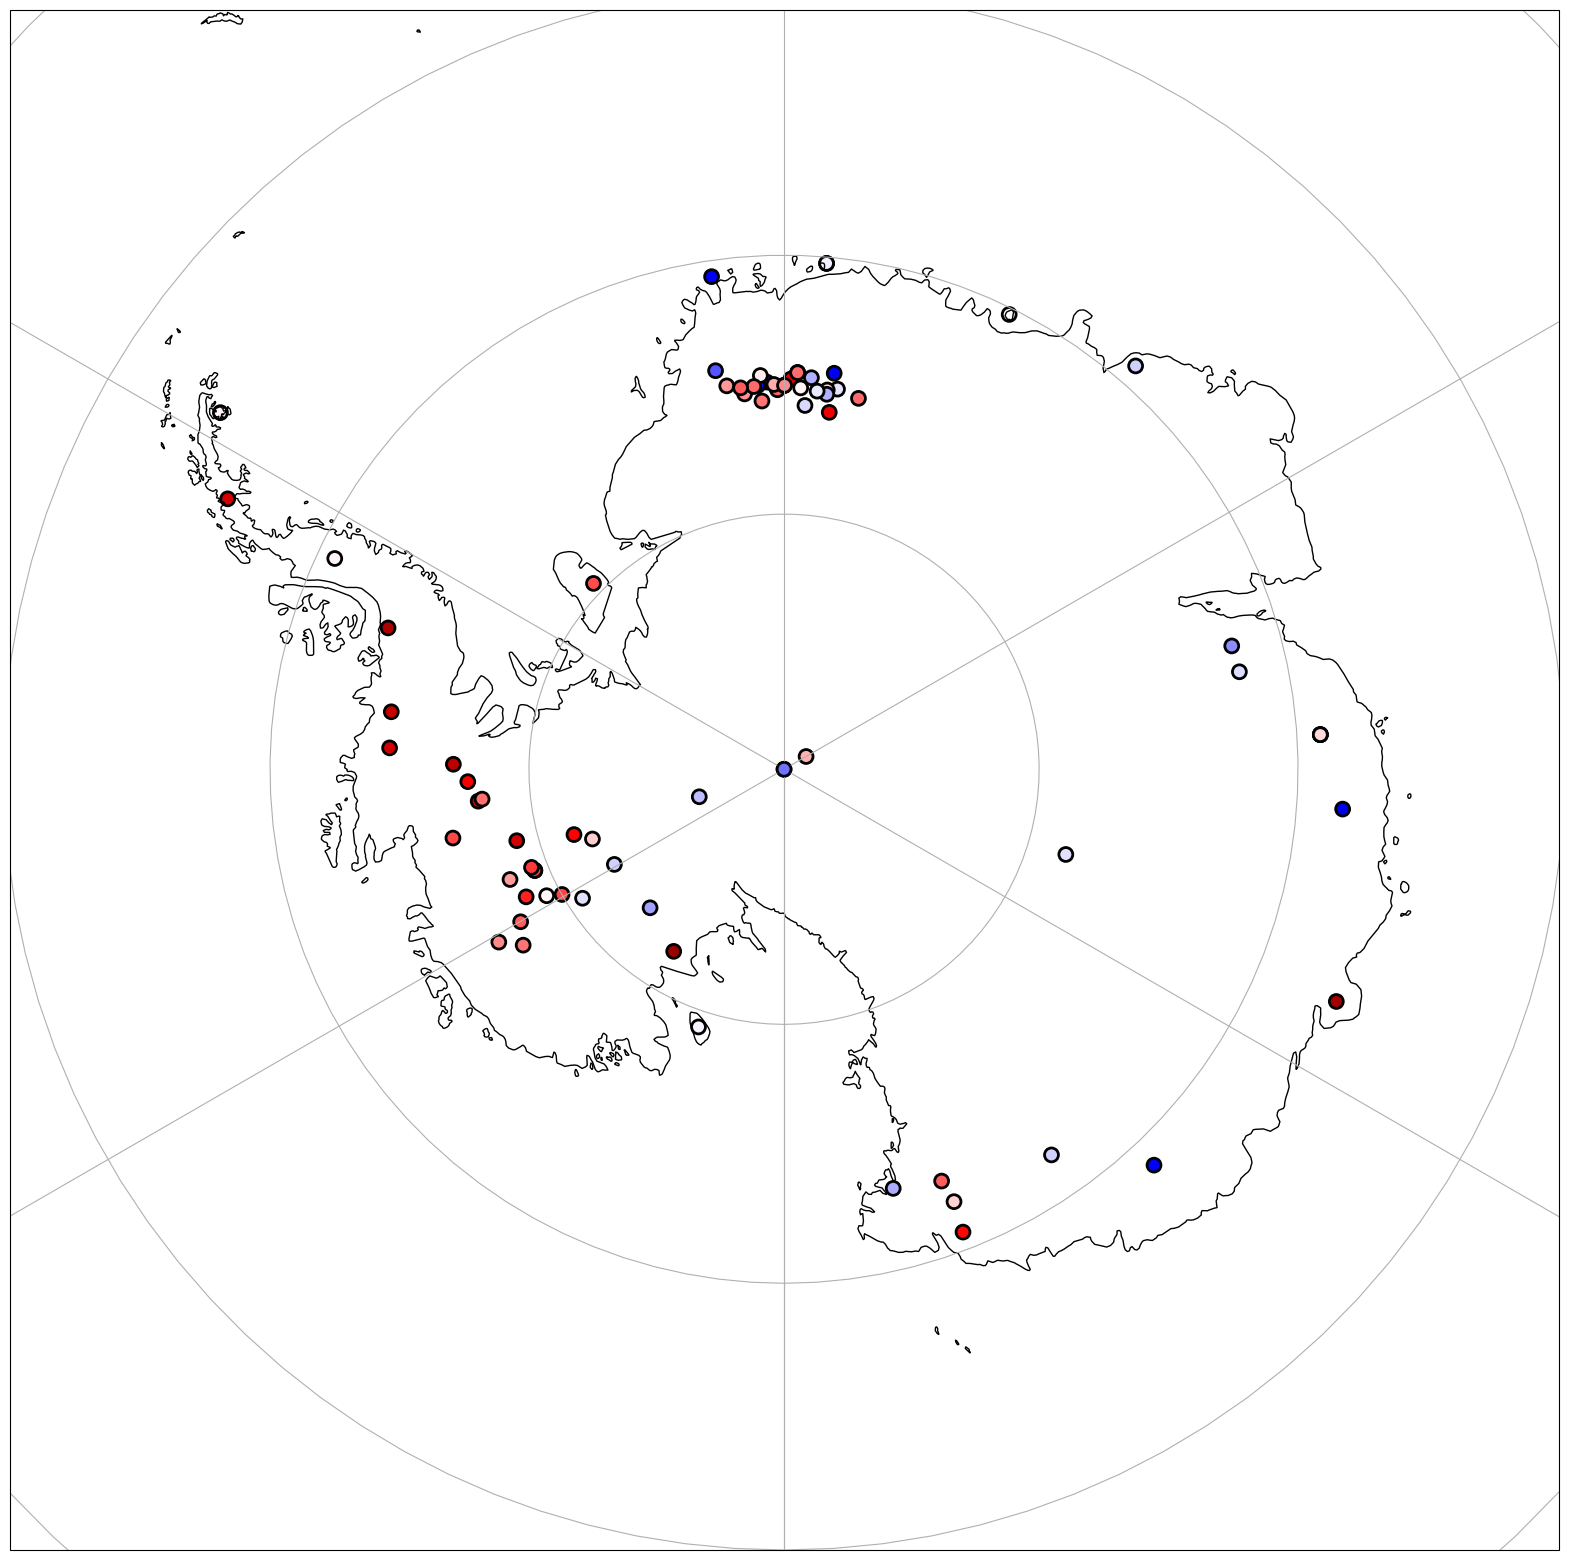

In [465]:
# Plotting the correlations between ice core accumulation records and ERA5 accumulation metric
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
ax.gridlines()

plt.rcParams['figure.figsize'] = [20, 20]


ax.coastlines()
plt.scatter(accumCoordsInd[:, 1], accumCoordsInd[:, 0], c=record_site_corr, s=100, linewidth=2, edgecolors='black', alpha=1, cmap=plt.cm.seismic, vmin=-1, vmax=1, zorder=1, transform=ccrs.PlateCarree())

plt.show()


In [442]:
print(racmo_points.shape)

(22, 84)


In [477]:
# computing core to grid cell RACMO correlations, linear regression
site_cont_corr = np.zeros(len(core_lats))
site_cont_slope = np.zeros(len(core_lats))
site_cont_intercept = np.zeros(len(core_lats))
site_error_var = np.zeros(len(core_lats))

for i in range(len(core_lats)):
    y = np.array(racmo_points[:, i]).reshape(-1, 1)
    x = np.array(ais_accum_racmo).reshape(-1, 1)
    
    site_cont_corr[i] = np.corrcoef(racmo_points[:, i], ais_accum_racmo)[0, 1]

    # Linear regression (least squares)
    reg = LinearRegression().fit(x, y)
    slope = reg.coef_[0][0]
    intercept = reg.intercept_[0]

    site_cont_slope[i] = slope
    site_cont_intercept[i] = intercept

    y_pred = lm.predict(x)

    error_var = np.var(y - y_pred, ddof=1)
    total_var = np.var(y, ddof=1)
    site_error_var[i] = error_var / total_var


In [636]:
# Loading the MME prior (size 1001 ensembles)
#accum_AIS_prior = np.array(pd.read_csv(home_path + path + "/MME_AIS_Accum.csv"))[:, 0]
kde = gaussian_kde(ais_accum_racmo)
x_b = kde.resample(100)[0]

num_years = 200
start_year = 1801
end_year = 2000
n_ens = len(x_b)
n_cores = accumCores.shape[1]

# Computing the Kalman gain matrix
B = np.var(x_b, ddof=1)
H = site_cont_slope.reshape(-1, 1)
R = np.diag(record_error_var)
R2 = np.diag(site_error_var)

S = B * (H @ H.T) + np.sqrt(R) + np.sqrt(R2)
#S = B * (H @ H.T)
BHt = (B * H.T)

S_inv = np.linalg.pinv(S)
K = BHt @ S_inv
#K[0, record_site_slope < 0.0] = 0.00001
K[0, 37] = 0.000001


posterior_ais = np.zeros((n_ens, num_years))

for i in range(num_years):
    currentYear = start_year + i

    x_a = np.zeros(n_ens)  # posterior ensemble

    for j in range(n_ens):
        y = site_PSM[i, :] # proxy observations for year i (84, )
        y_e = np.zeros(n_cores)  # expected proxy observations for year i (84, )

        mask = ~np.isnan(y)

        for k in range(n_cores):
            """
            if not(np.isnan(site_PSM[:, k]).any()):
                y_e[k] = site_cont_intercept[k] + site_cont_slope[k] * x_b[j] # implementing the PSM 
            else:
                y_e[k] = y[k]
            """
            y_e[k] = site_cont_intercept[k] + site_cont_slope[k] * x_b[j]

        y_valid = y[mask]
        y_e_valid = y_e[mask]
        K_valid = K[:, mask]
        
        x_a[j] = x_b[j] + K_valid @ (y_valid - y_e_valid)  # kalman update


    posterior[:, i] = x_a

/var/folders/4d/5th1wr_s21g614c74mcbh9kc0000gn/T/ipykernel_56105/1741659894.py:54: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_a[j] = x_b[j] + K_valid @ (y_valid - y_e_valid)  # kalman update


[[1.         0.66856795]
 [0.66856795 1.        ]]


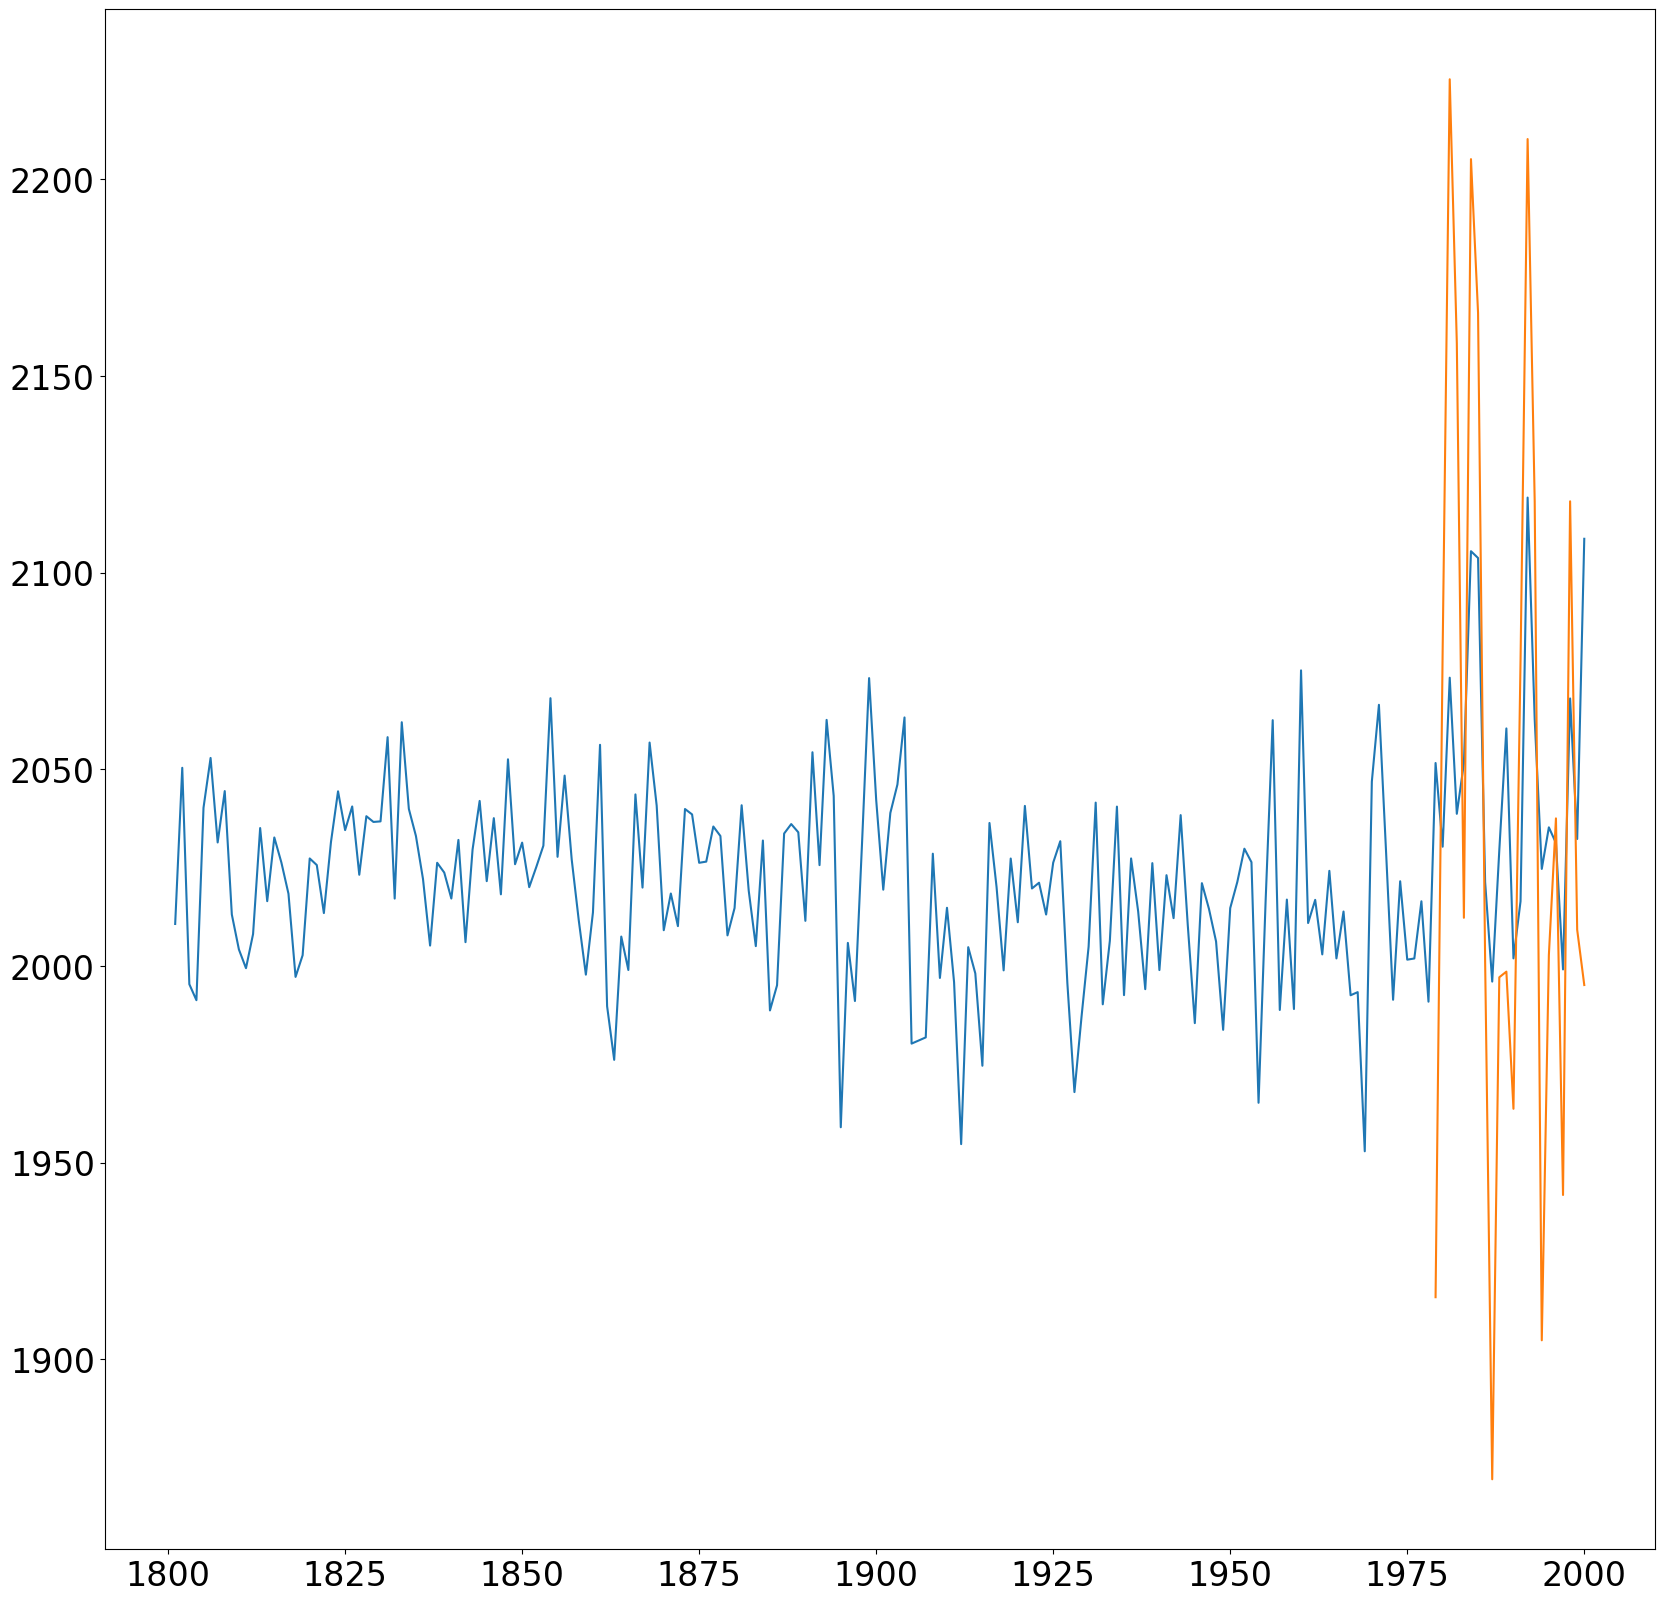

In [637]:
satYears = np.arange(1979, 2001)

posterior_mean = np.mean(posterior, axis=0)
print(np.corrcoef(posterior_mean[178:], ais_accum_racmo))

plt.plot(fullYears, posterior_mean)
plt.plot(satYears, ais_accum_racmo)
plt.tick_params(axis='both', which='major', labelsize=24)

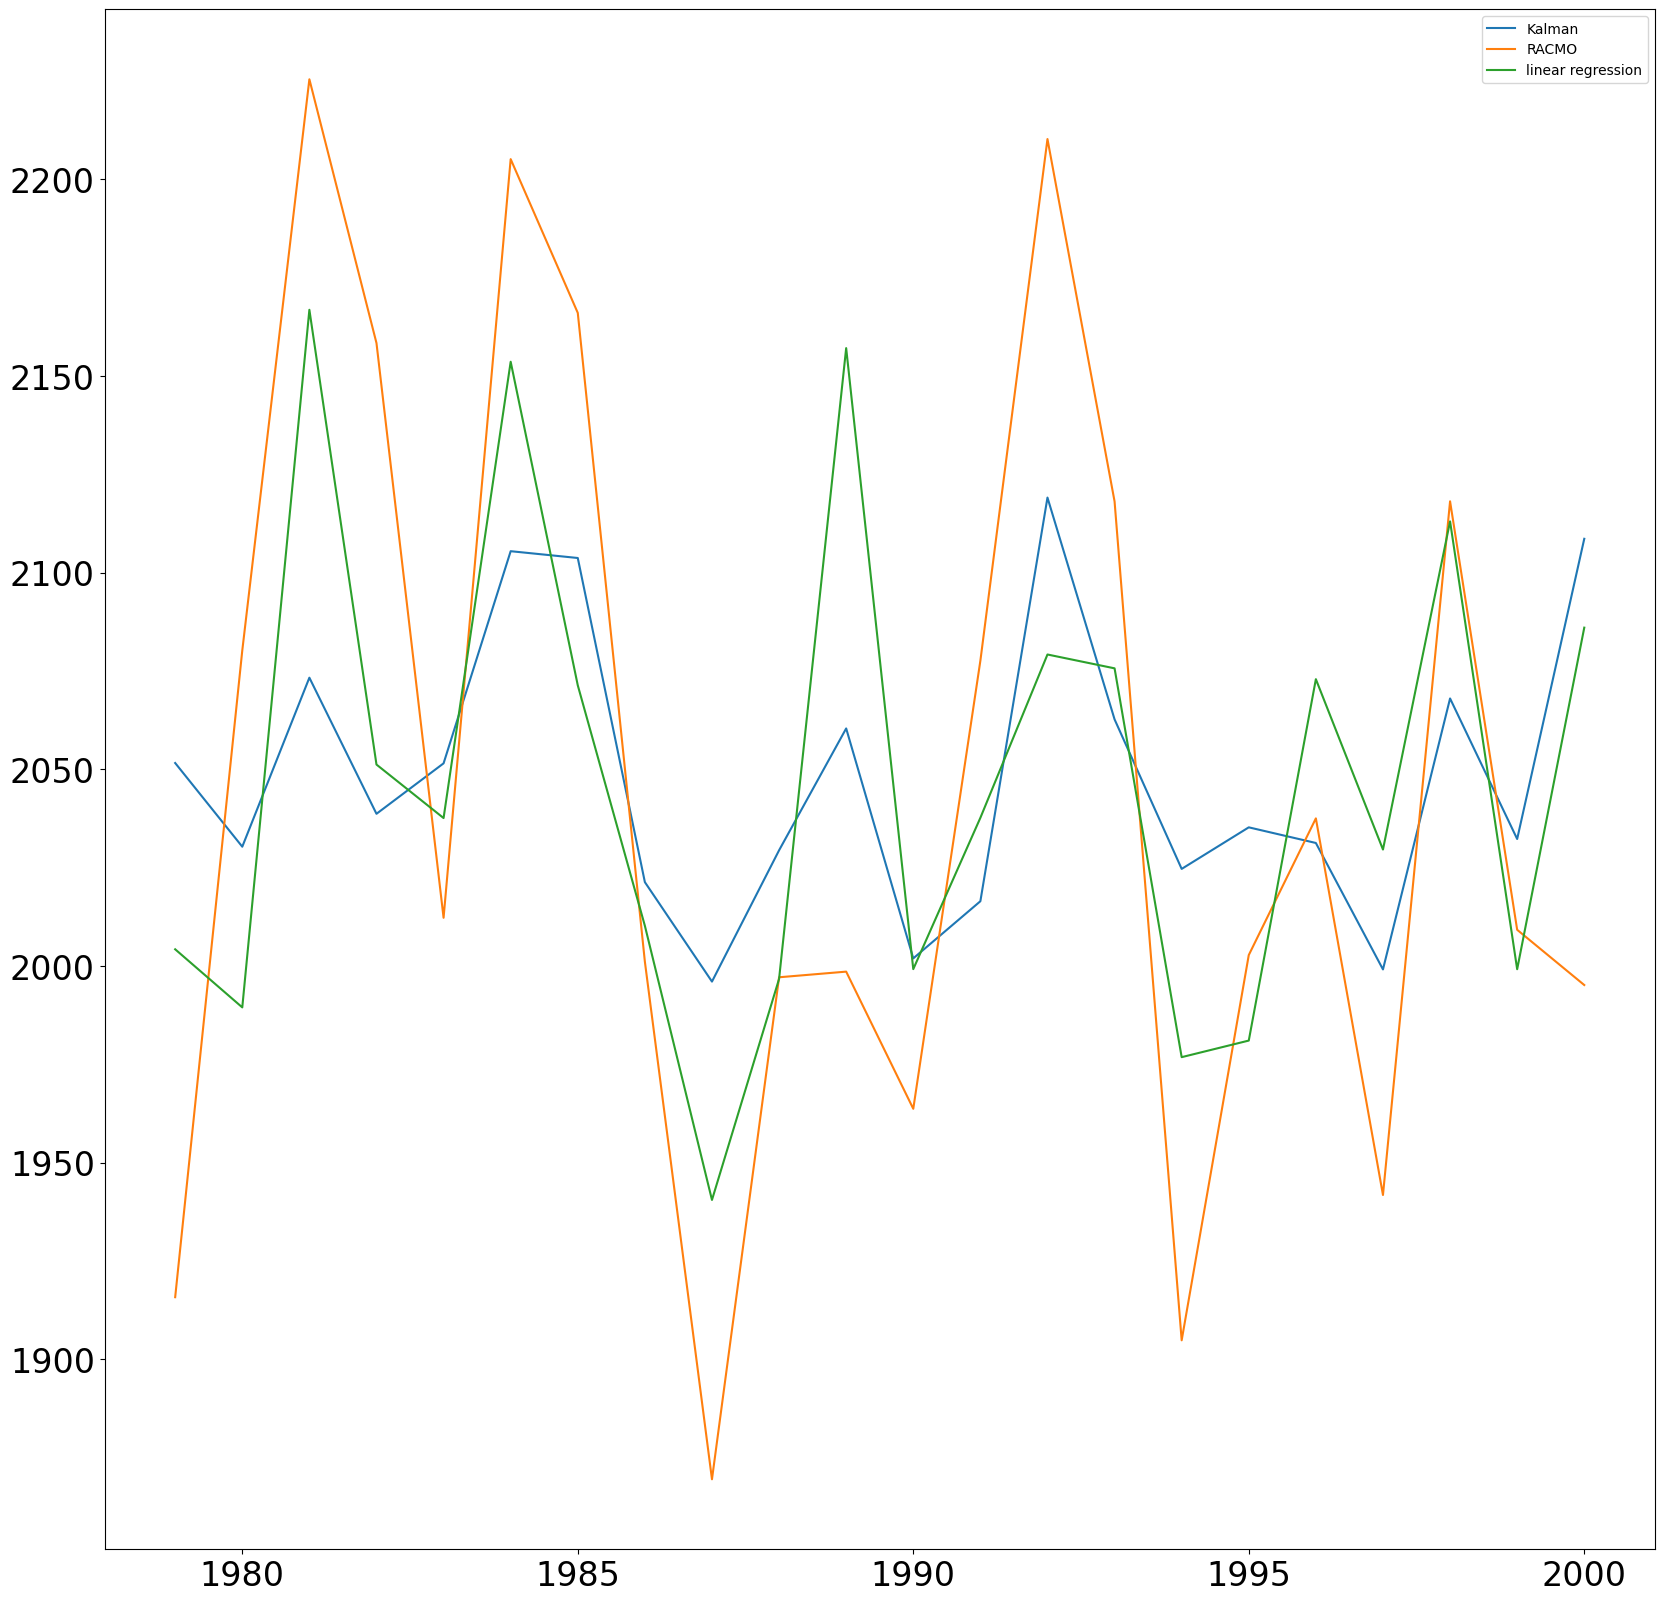

In [638]:
plt.plot(satYears, posterior_mean[178:], label='Kalman')
plt.plot(satYears, ais_accum_racmo, label='RACMO')
plt.plot(satYears, y_pred[178:], label='linear regression')
plt.tick_params(axis='both', which='major', labelsize=24)
plt.legend()

In [642]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge

imputer = SimpleImputer(strategy='mean')

X_train_imputed = imputer.fit_transform(racmo_points)
X_test_imputed = imputer.transform(site_PSM)  # use the same stats as training
y_train = ais_accum_racmo.ravel()

# Initialize and fit the model
# Using Ridge for better performance with few samples and many features
model = Ridge(alpha=1.0)  # alpha can be tuned
model.fit(X_train_imputed, y_train)

model = LinearRegression()
model.fit(racmo_points, ais_accum_racmo.ravel())

y_pred = model.predict(X_test_imputed)

[[1.         0.69150547]
 [0.69150547 1.        ]]


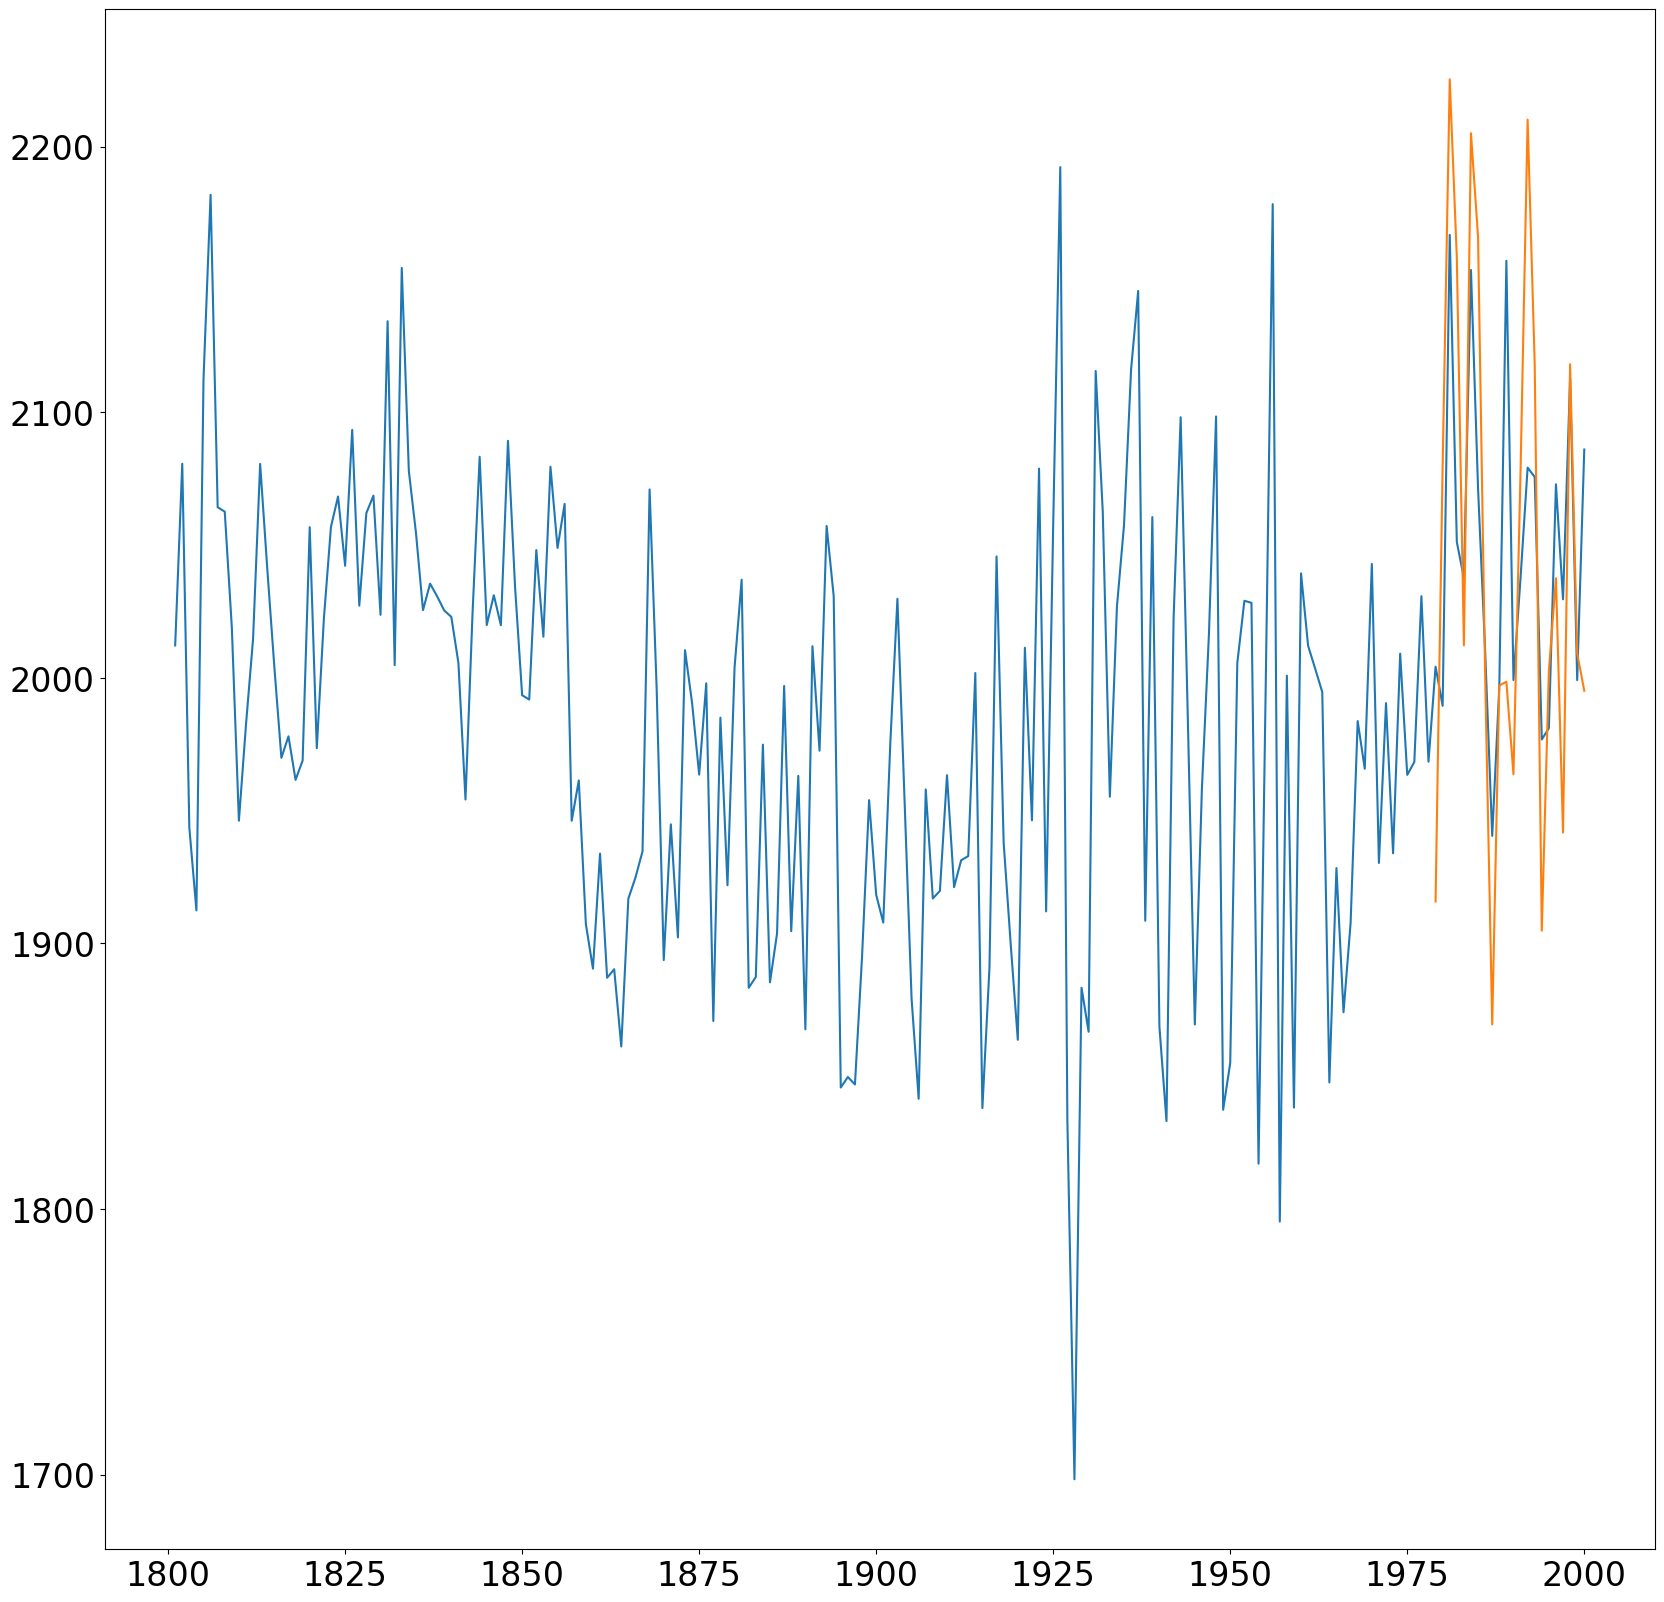

In [643]:
satYears = np.arange(1979, 2001)

print(np.corrcoef(y_pred[178:], ais_accum_racmo))

plt.plot(fullYears, y_pred)
plt.plot(satYears, ais_accum_racmo)
plt.tick_params(axis='both', which='major', labelsize=24)

[[1.         0.69150547]
 [0.69150547 1.        ]]


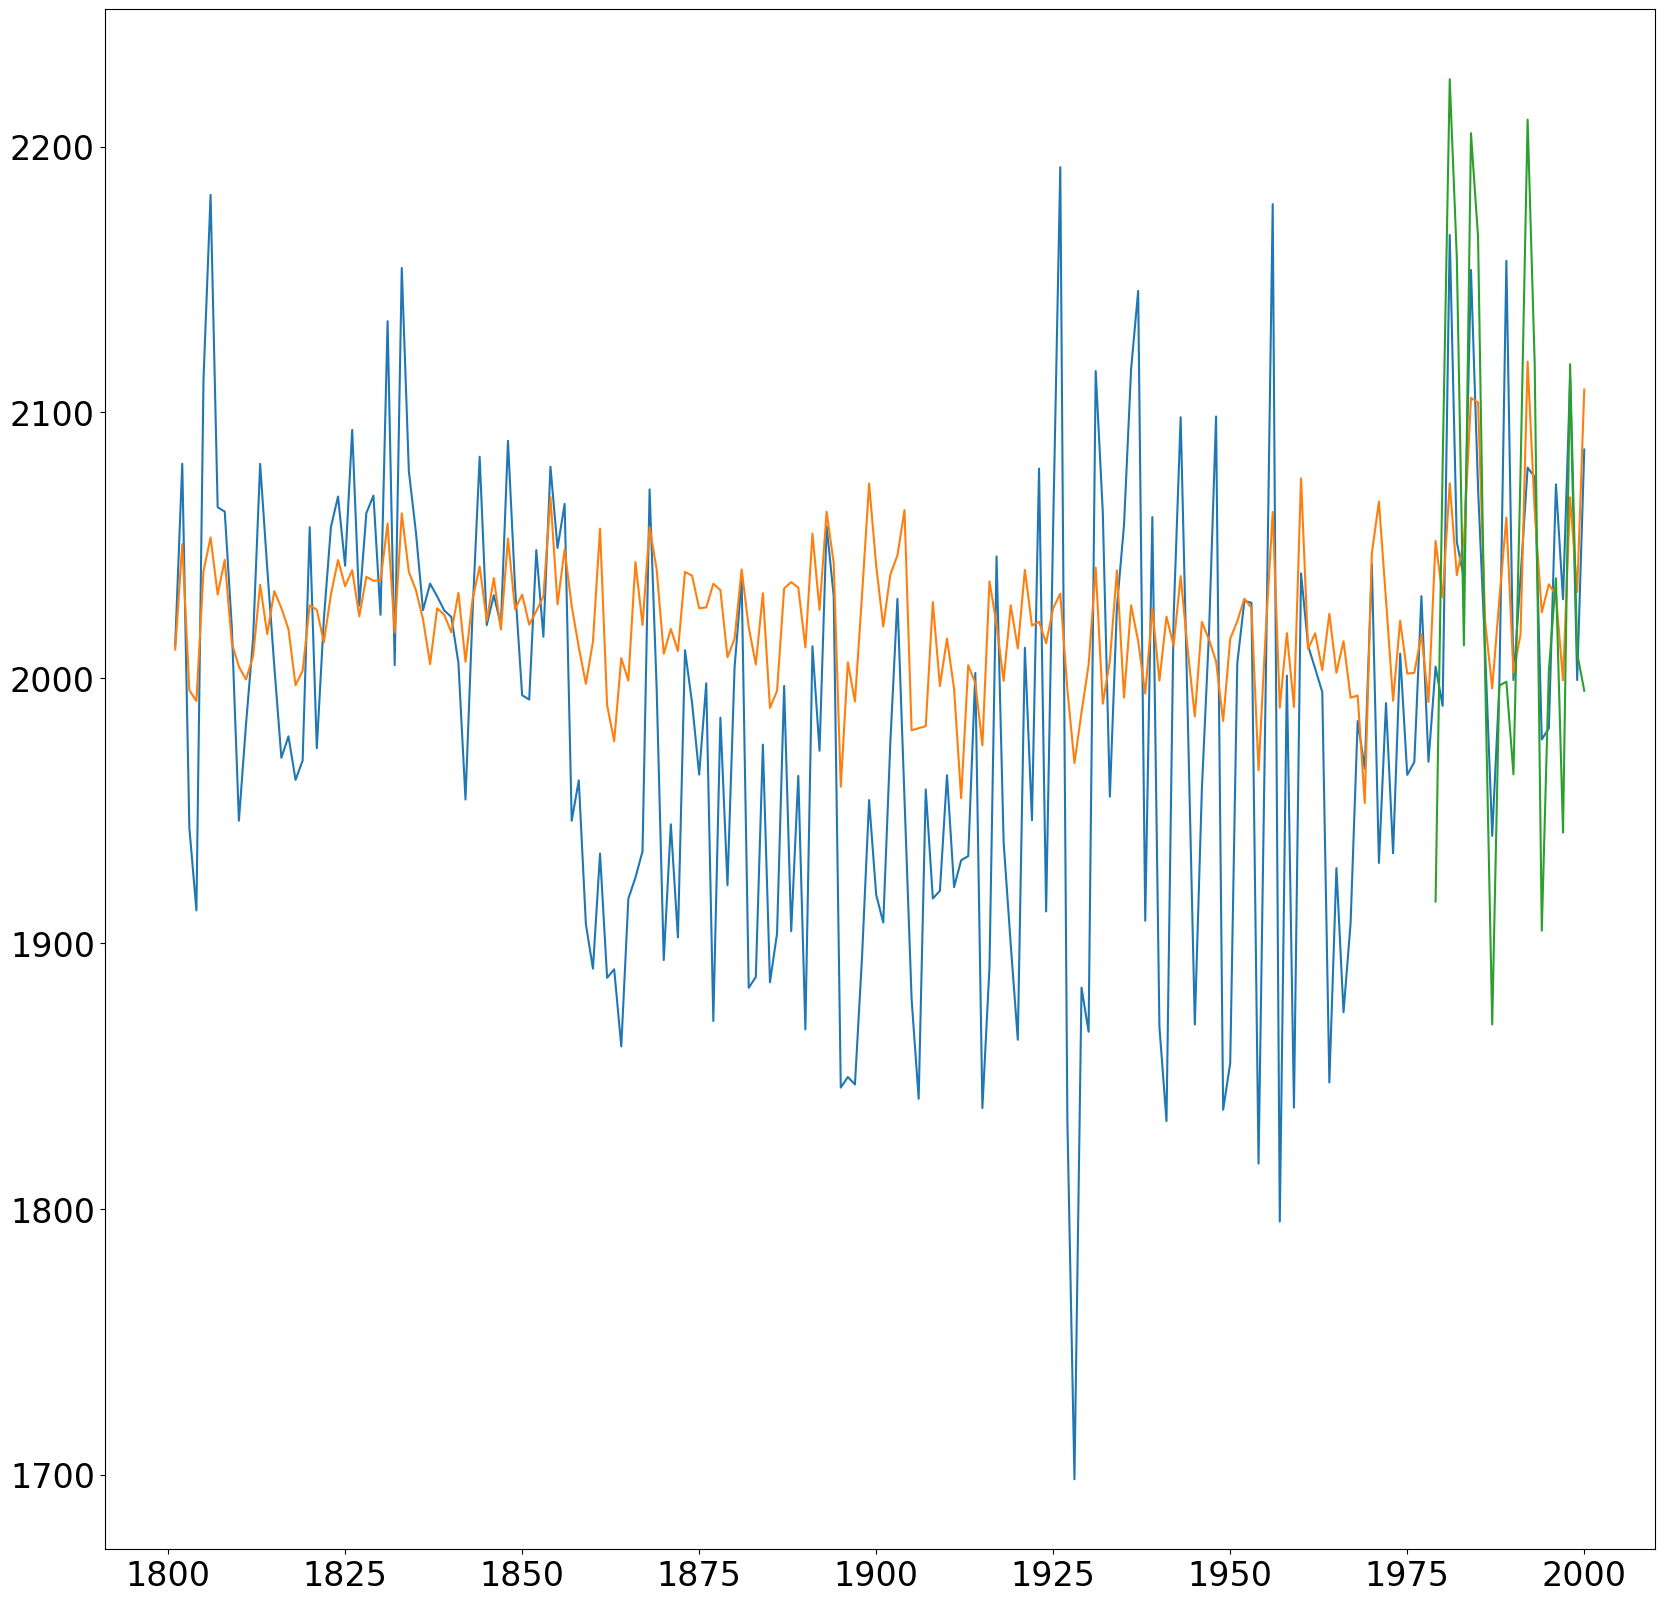

In [644]:
satYears = np.arange(1979, 2001)

print(np.corrcoef(y_pred[178:], ais_accum_racmo))

plt.plot(fullYears, y_pred)
plt.plot(fullYears, posterior_mean)
plt.plot(satYears, ais_accum_racmo)
plt.tick_params(axis='both', which='major', labelsize=24)

In [652]:
slope, intercept = np.polyfit(fullYears[100:156], posterior_mean[100:156], 1)

print("Slope:", slope)

Slope: 0.07512656735380673


In [663]:
mean_19th = np.mean(posterior_mean[0:100])
anomaly = posterior_mean - mean_19th
# Cumulative integral from 1801 onward
cumulative_integral = np.cumsum(anomaly)  # simple rectangle rule

integral_20th_century = cumulative_integral[100:200]  # years 1901-2000



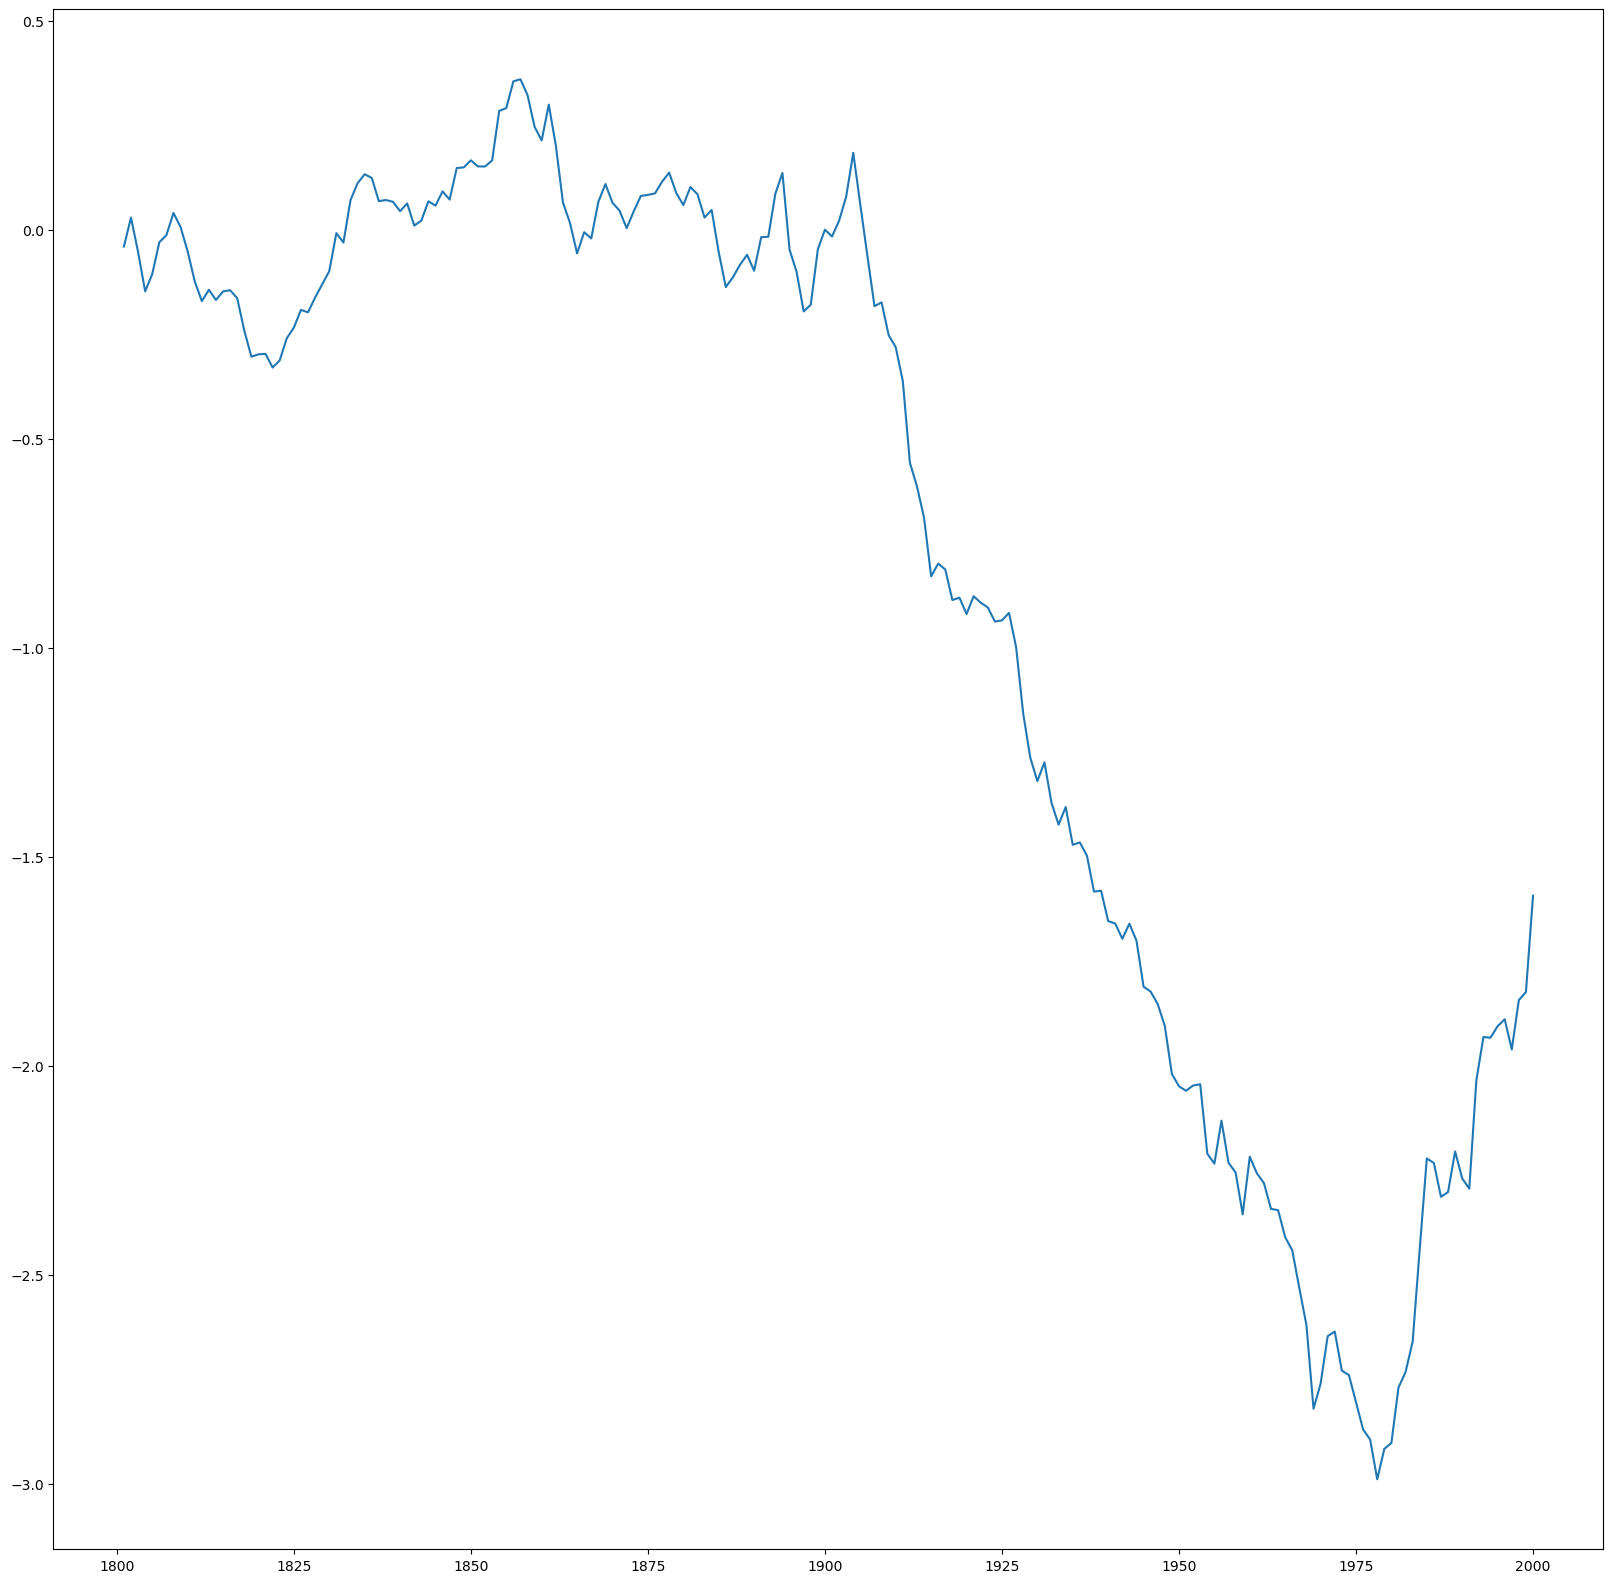

In [664]:
plt.plot(fullYears, cumulative_integral/361.8)